In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os

# Import the MFI library 
import MFI_lib1D as lib1
import MFI_class1D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_ReInit"): print("\nThe data folder \"_data_ReInit\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_ReInit/"); 
    path_data = path_notebook + "/_data_ReInit/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})


# Load the grid, the FES, and the PLUMED grid. Change n_surf to select the surface.  
for _surf_parameters_ in [0]:
    [grid, y_list, y_string_list] = lib1.load_pkl(path_notebook + "/fes_list_1D")
    FES_cutoff_list = [30, 40, 40, 50, 50, 80, 60, 70, 70, 80, 80, 90, 80, 90, 90, 100, 100, 100, 110, 110]
    n_surf = 4
    y = y_list[n_surf]
    FES_cutoff = FES_cutoff_list[n_surf]
    y_string = y_string_list[n_surf]  
    plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x FUNC=({y_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
    dx, dy = grid[1] - grid[0], np.gradient(y, grid[1] - grid[0]) 
    [pl_x, pl_min, pl_max, pl_n, pl_ext] = lib1.get_plumed_grid_1D(grid, -7, 7, print_info=True)
    # plt.figure(figsize=(5,4)); plt.plot(grid, y); plt.xlabel("x"); plt.ylabel("Free Energy [kJ/mol]"); plt.title("Free Energy Surface"); plt.show()

The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class1D
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class1D/_data_ReInit/
The MFI grid was: 
xmin= -6.0  xmax= 6.0  nx= 501

The new PLUMED grid is: 
pl_xmin= -7.01  pl_xmax= 7.01  pl_nx= 585


In [10]:
### Reload modules
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1); pass

### Define default parameters

In [3]:
default_params = {	"grid":grid, "y":y, "bw":dx*1.5, "periodic":False, # "dy":dy, "initial_position":[0,0], 
					"System":"Langevin", "plumed_dat_text":plumed_dat_text, "pl_grid":pl_x, "simulation_steps": 500_000, 
					"position_pace":50, "metad_pace":500, "n_pos_per_window":10, 
     				"metad_width":0.1, "metad_height":5, "biasfactor":50 , 
         			"Bias_sf":1.05, "gaus_filter_sigma":1, 
					"FES_cutoff":FES_cutoff, "calculate_FES_st_dev":True, "bootstrap_iter":50,
     				"simulation_folder_path": path_data, "print_info": True}

### Run 1st simulation: t_sim = 0 -> 2.5 ns (Exploration) (1_000 hills - 500_000 steps)

| 100% | AAD: 0.572 [kJ/mol] | Total time: 13 sec                                                            


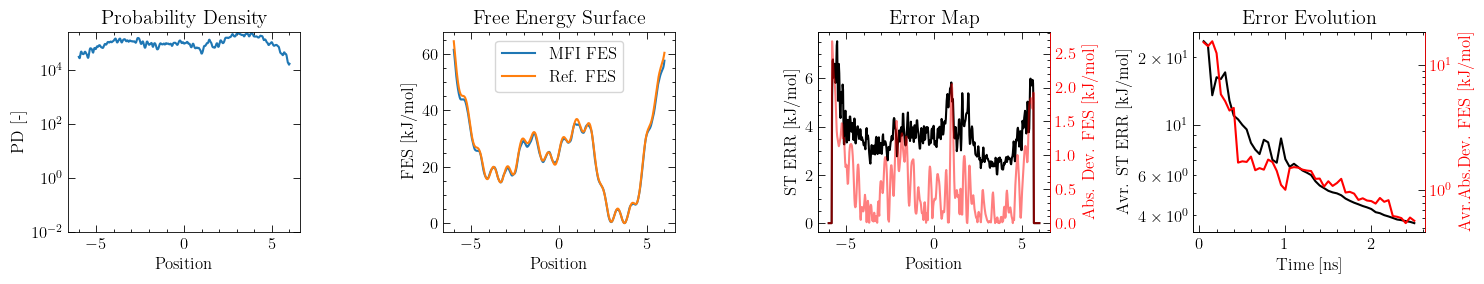

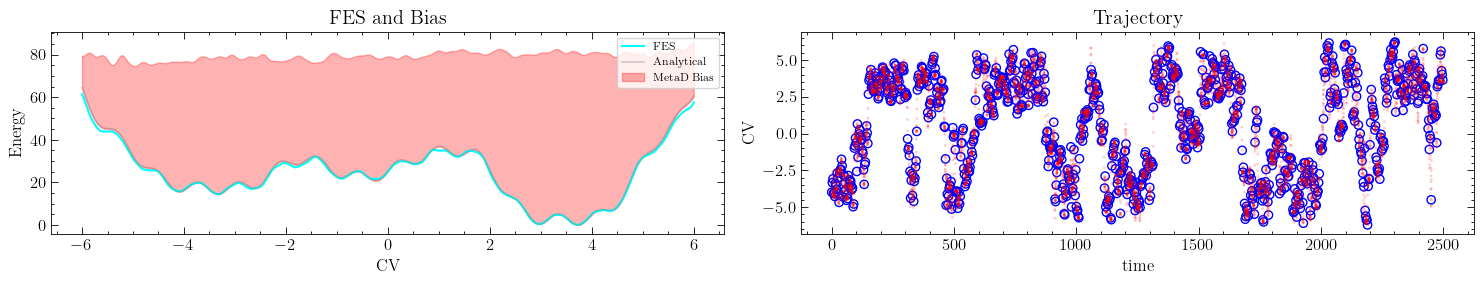

In [5]:
new_params = {**default_params}
new_params.update({"ID":"_1"})

## Load MFI object
MFI = MFI_class1D.MFI1D(**new_params)

## Run the simulation
# MFI.run_simulation()

## Analyse the data
MFI.analyse_data()

## Plot the results and save the data for later use
MFI.plot_results()
lib1.plot_FES_Bias_and_Traj(grid=MFI.grid, fes=MFI.FES, metad_bias=MFI.Bias, position=MFI.position, hills=MFI.hills, y=MFI.y )
t1, aofe1, aad1 = np.array(MFI.Avr_Error_list)[:,0], np.array(MFI.Avr_Error_list)[:,2], np.array(MFI.Avr_Error_list)[:,MFI.aad_index]


### Run 2nd simulation: t_sim = 2.5 -> 5 ns (MetaD) (1_000 hills - 500_000 steps)

| 100% | AAD: 0.609 [kJ/mol] | Total time: 14 sec                                                            


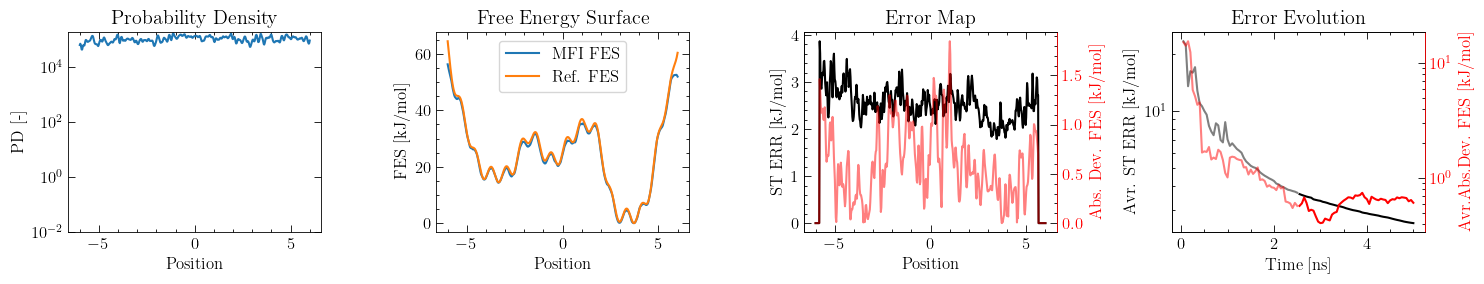

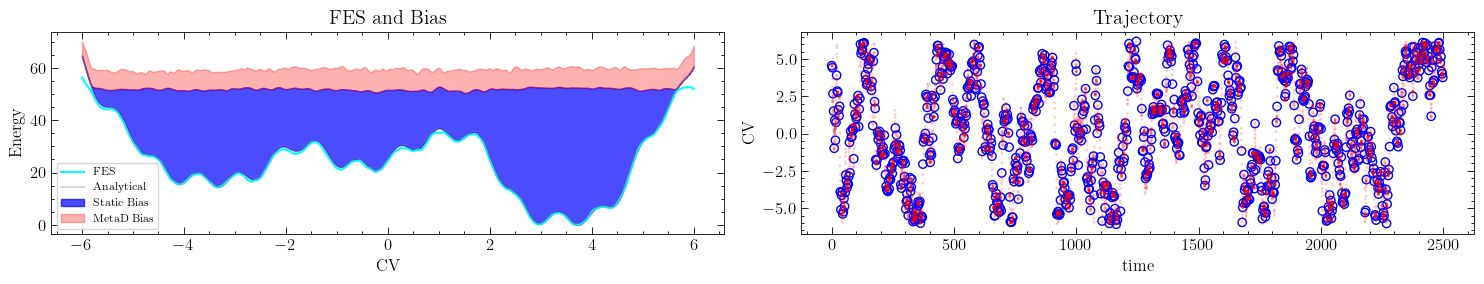

In [6]:
new_params = {**default_params}
new_params.update({"ID":"_2", "metad_height":2, "metad_width":0.05, "biasfactor":5})
new_params.update({"base_forces":MFI.force_terms, "base_time":MFI.sim_time, "biasfactor":5})

## Load MFI object
MFI2 = MFI_class1D.MFI1D(**new_params)

## Make the external bias
MFI2.make_external_bias(MFI.FES)

## Run the simulation
# MFI2.run_simulation()

## Analyse the data
MFI2.analyse_data()

## Plot the results and save the data for later use
MFI2.plot_results(more_aofe=[t1, aofe1] , more_aad = [t1, aad1])
lib1.plot_FES_Bias_and_Traj(grid=MFI2.grid, fes=MFI2.FES, metad_bias=MFI2.Bias, static_bias=MFI2.Bias_static, position=MFI2.position, hills=MFI2.hills, y=MFI2.y )
t2, aofe2, aad2 = np.array(MFI2.Avr_Error_list)[:,0], np.array(MFI2.Avr_Error_list)[:,2], np.array(MFI2.Avr_Error_list)[:,MFI2.aad_index]


### Run 3rd simulation: t_sim = 5 -> 7.5 ns (MetaD) (1_000 hills - 500_000 steps)

| 100% | AAD: 0.356 [kJ/mol] | Total time: 14 sec                                                            


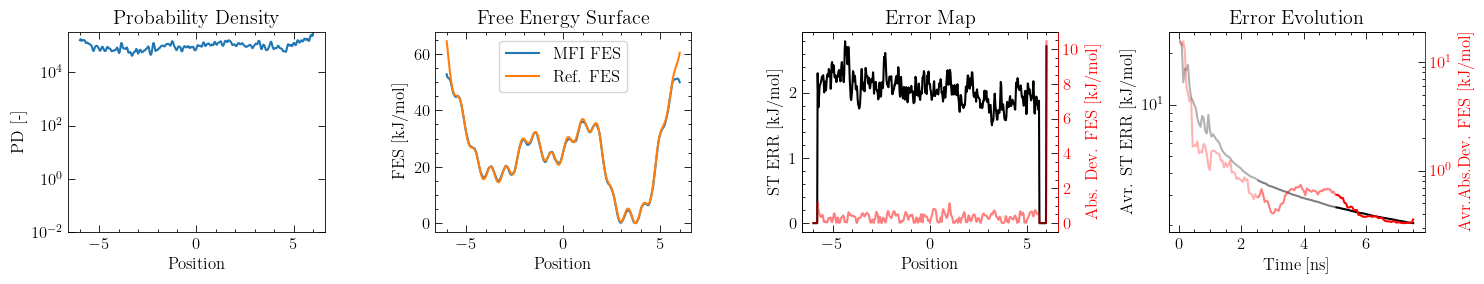

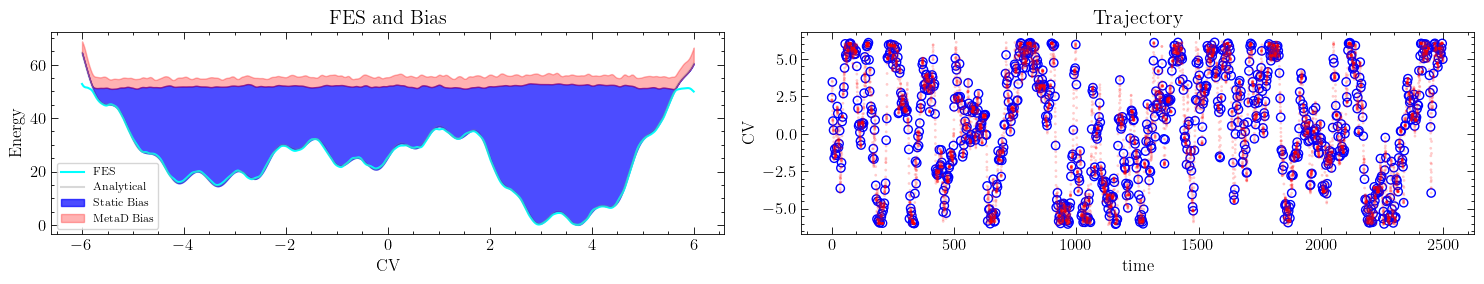

In [9]:
new_params = {**default_params}
new_params.update({"ID":"_3", "metad_height":1, "metad_width":0.05, "biasfactor":3})
new_params.update({"base_forces":lib1.patch_forces(MFI.force_terms, MFI2.force_terms)})
new_params.update({"base_time":MFI.sim_time+MFI2.sim_time})

## Load MFI object
MFI3 = MFI_class1D.MFI1D(**new_params)

## Make the external bias
MFI3.make_external_bias(MFI2.FES)

## Run the simulation
# MFI3.run_simulation()
	
## Analyse the data
MFI3.analyse_data()

## Plot the results and save the data for later use
MFI3.plot_results(more_aofe=[[t1, aofe1], [t2, aofe2]] , more_aad = [[t1, aad1], [t2, aad2]])
lib1.plot_FES_Bias_and_Traj(grid=MFI3.grid, fes=MFI3.FES, metad_bias=MFI3.Bias, static_bias=MFI3.Bias_static, position=MFI3.position, hills=MFI3.hills, y=MFI3.y )
t3, aofe3, aad3 = MFI3.Avr_Error_list[:,0], MFI3.Avr_Error_list[:,2], MFI3.Avr_Error_list[:,MFI3.aad_index]


### Run 4th simulation: t_sim = 7.5 -> 10 ns (Flat Sampling)


Running Langevin dynamics: n_steps=500,000, ipos=-2.89, Pos_t=50, T=1, t_Tot=2.50ns
Static bias used: external_bias.dat 

| 100% | Simulated time: 2.5002ns | Total time: 5 sec | Finished at 12:52:47                                                         

Langevin dynamics finished in 5 sec.
| 100% | AAD: 0.284 [kJ/mol] | Total time: 14 sec                                                            


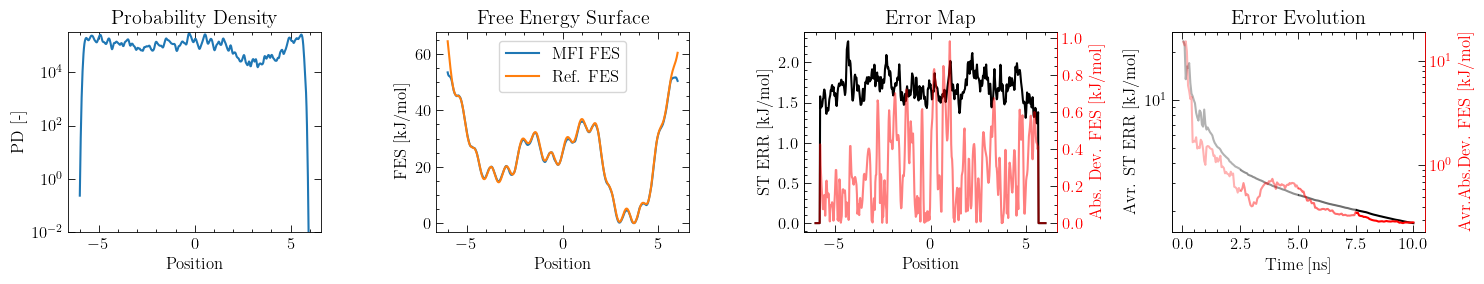

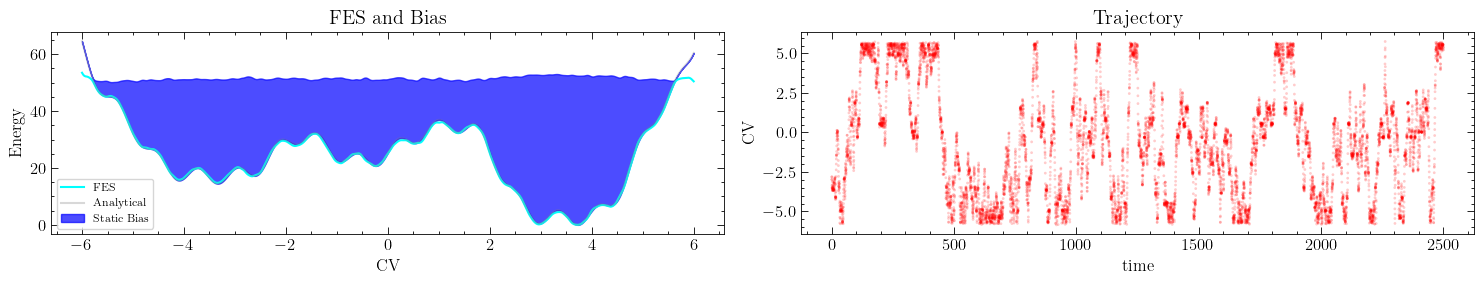

In [13]:
new_params = {**default_params}
new_params.update({"ID":"_4", "metad_height":None, "metad_width":None, "biasfactor":None})
new_params.update({"base_forces":lib1.patch_forces([MFI.force_terms, MFI2.force_terms, MFI3.force_terms])})
new_params.update({"base_time":MFI.sim_time+MFI2.sim_time+MFI3.sim_time})

## Load MFI object
MFI4 = MFI_class1D.MFI1D(**new_params)

## Make the external bias
MFI4.make_external_bias(MFI3.FES)

# #Run the simulation
# MFI4.run_simulation()

## Analyse the data
MFI4.analyse_data()

## Plot the results and save the data for later use
MFI4.plot_results(more_aofe=[[t1, aofe1], [t2, aofe2], [t3, aofe3]] , more_aad = [[t1, aad1], [t2, aad2], [t3, aad3]])
lib1.plot_FES_Bias_and_Traj(grid=MFI4.grid, fes=MFI4.FES, static_bias=MFI4.Bias_static, position=MFI4.position, y=MFI4.y )
t4, aofe4, aad4 = MFI4.Avr_Error_list[:,0], MFI4.Avr_Error_list[:,2], MFI4.Avr_Error_list[:,MFI4.aad_index]


### Run 5th simulation: t_sim = 10 -> 12.5 ns (Flat Sampling)


Running Langevin dynamics: n_steps=500,000, ipos=-3.05, Pos_t=50, T=1, t_Tot=2.50ns
Static bias used: external_bias.dat 

| 100% | Simulated time: 2.5002ns | Total time: 5 sec | Finished at 12:53:13                                                         

Langevin dynamics finished in 5 sec.
| 100% | AAD: 0.23 [kJ/mol] | Total time: 14 sec                                                            


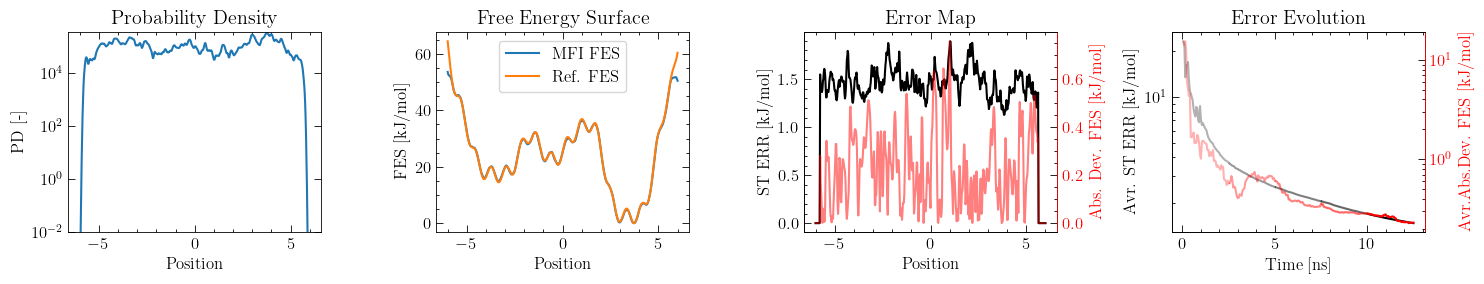

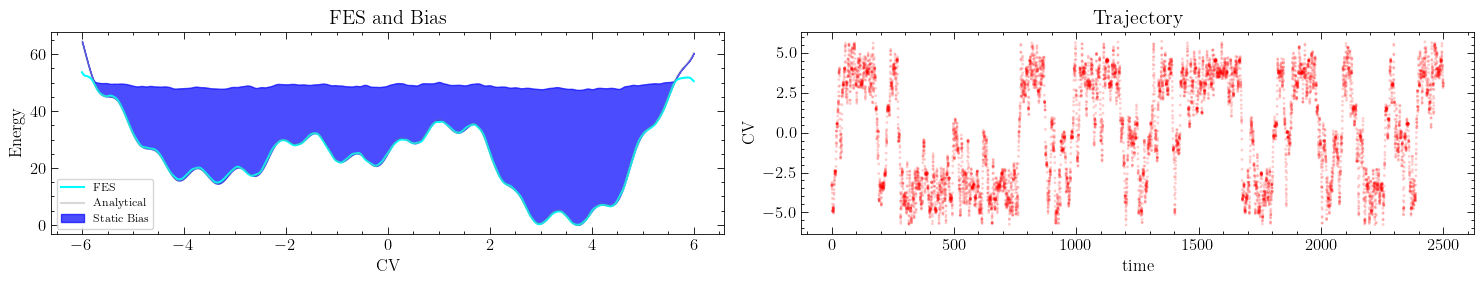

In [14]:
new_params = {**default_params}
new_params.update({"ID":"_5", "metad_height":None, "metad_width":None, "biasfactor":None})
new_params.update({"Bias_sf":0.95})
new_params.update({"base_forces":lib1.patch_forces([MFI.force_terms, MFI2.force_terms, MFI3.force_terms, MFI4.force_terms])})
new_params.update({"base_time":MFI.sim_time+MFI2.sim_time+MFI3.sim_time+MFI4.sim_time})

## Load MFI object
MFI5 = MFI_class1D.MFI1D(**new_params)

## Make the external bias
MFI5.make_external_bias(MFI4.FES)

# # Run the simulation
# MFI5.run_simulation()

## Analyse the data
MFI5.analyse_data()

## Plot the results and save the data for later use
MFI5.plot_results(more_aofe=[[t1, aofe1], [t2, aofe2], [t3, aofe3], [t4, aofe4]] , more_aad = [[t1, aad1], [t2, aad2], [t3, aad3], [t4, aad4]])
lib1.plot_FES_Bias_and_Traj(grid=MFI5.grid, fes=MFI5.FES, static_bias=MFI5.Bias_static, position=MFI5.position, y=MFI5.y )
t5, aofe5, aad5 = MFI5.Avr_Error_list[:,0], MFI5.Avr_Error_list[:,2], MFI5.Avr_Error_list[:,MFI5.aad_index]


### Run 6th simulation: t_sim = 12.5 -> 15.0 ns (Umbrella sampling)


Running Langevin dynamics: n_steps=500,000, ipos=-1.0, Pos_t=50, T=1, t_Tot=2.50ns
Harmonic potential: centre=-1.0, kappa=0.2
Static bias used: external_bias.dat 

| 100% | Simulated time: 2.5002ns | Total time: 5 sec | Finished at 12:54:02                                                         

Langevin dynamics finished in 5 sec.
| 100% | AAD: 0.211 [kJ/mol] | Total time: 14 sec                                                            


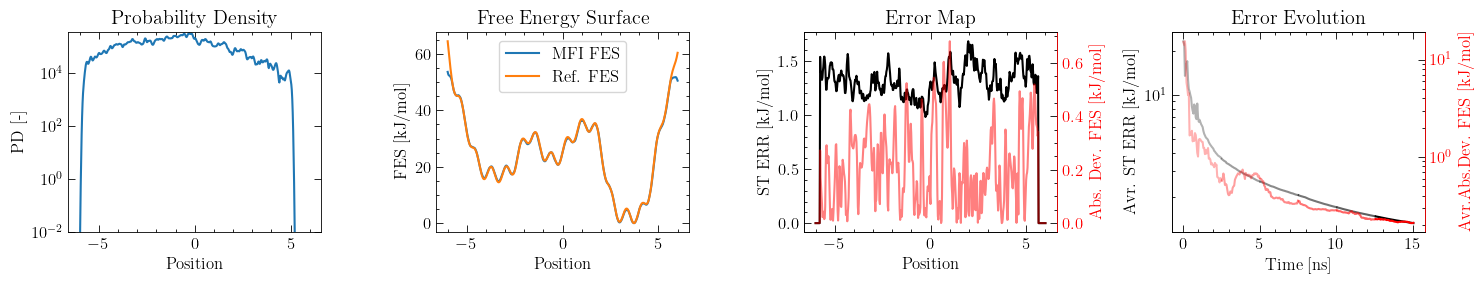

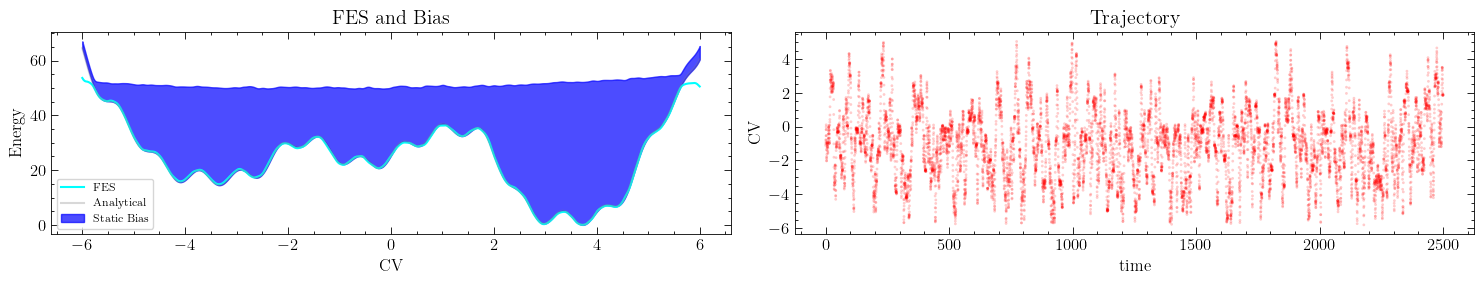

In [18]:
new_params = {**default_params}
new_params.update({"ID":"_6", "metad_height":None, "metad_width":None, "biasfactor":None})
new_params.update({"Bias_sf":1.0})
new_params.update({"hp_centre":-1.0, "initial_position":-1.0, "hp_kappa":0.2})
new_params.update({"base_forces":lib1.patch_forces([MFI.force_terms, MFI2.force_terms, MFI3.force_terms, MFI4.force_terms, MFI5.force_terms])})
new_params.update({"base_time":MFI.sim_time+MFI2.sim_time+MFI3.sim_time+MFI4.sim_time+MFI5.sim_time})

# same input as MFI before
MFI6 = MFI_class1D.MFI1D(**new_params)

# # Make the external bias
MFI6.make_external_bias(MFI5.FES)

# # Run the simulation
# MFI6.run_simulation()

## Analyse the data
MFI6.analyse_data()	


MFI6.plot_results(more_aofe=[[t1, aofe1], [t2, aofe2], [t3, aofe3], [t4, aofe4], [t5, aofe5]] , more_aad = [[t1, aad1], [t2, aad2], [t3, aad3], [t4, aad4], [t5, aad5]])
lib1.plot_FES_Bias_and_Traj(grid=MFI6.grid, fes=MFI6.FES, static_bias=MFI6.Bias_static, position=MFI6.position, y=MFI6.y )
t6, aofe6, aad6 = MFI6.Avr_Error_list[:,0], MFI6.Avr_Error_list[:,2], MFI6.Avr_Error_list[:,MFI6.aad_index]


### Make nice plot

In [16]:
def make_nice_figure(*MFI_instances, save_path=None, t_range=None, aofe_range=None, aad_range=None, end_exploration=None, end_metad=None, end_flat=None, plot_show=True):
        
    if len(MFI_instances) > 0: MFI_plot, plot_MFI = MFI_instances[-1], True
    else: plot_MFI = False

    ### --- Plot FES and surface ------------ ###
    plt.figure(figsize=(6,6))
    plt.subplot(2,2,1)
    if "y" in locals(): plt.plot(grid, y, label="Analytical", color="grey", alpha=0.3)
    plt.title("FES and Bias"); plt.xlabel("s"); plt.ylabel("Energy [kJ/mol]")
    
    if plot_MFI: 
        plt.plot(grid, MFI_plot.FES, label="cyan")
        plt.fill_between(grid, y , y + MFI_plot.Bias_static, alpha=0.3, color="red", label="MetaD")
        plt.fill_between(grid, y + MFI_plot.Bias_static, y + MFI_plot.Bias_static + MFI_plot.Bias, alpha=0.3, color="orange", label="MetaD")
    # plt.legend(fontsize=10)

    ### --- Plot error map ------------ ###
    ax3 = plt.subplot(2,2,2)
    ax3_2 = ax3.twinx()
    
    if plot_MFI: 
        ax3.plot(MFI_plot.grid, MFI_plot.ofe, color="black")
        ax3_2.plot(MFI_plot.grid, MFI_plot.AD, color="red", alpha=0.5)
    
    ax3.set_title("Error Map"); ax3.set_xlabel("s"); ax3.set_ylabel("$\sigma$(Force) [kJ/mol]")
    ax3_2.set_ylabel("AD. FES [kJ/mol]", color="red")
    ax3_2.tick_params(axis='y', labelcolor="red"); ax3_2.spines['right'].set_color('red')
    ax3.set_yscale("symlog", linthresh=0.1)
    ax3.set_ylim(0, 100)
    ax3_2.set_yscale("symlog", linthresh=0.01)
    ax3_2.set_ylim(0, 100)

    ### --- Plot error progression ------------ ###
    ax4 = plt.subplot(2,1,2)
    ax4_2 = ax4.twinx()
    
    if plot_MFI: 
        
        if t_range is None: 
            t_min, t_max = 1E6, 0
            for i in range(len(MFI_instances)): t_max, t_min = max(t_max, np.max(MFI_instances[i].Avr_Error_list[:,0])), min(t_min, np.min(MFI_instances[i].Avr_Error_list[:,0]))
            t_min, t_max = t_min*0.9, t_max*1.1
        else: t_min, t_max = t_range
        if aofe_range is None:
            aofe_min, aofe_max = 1E6, 0
            for i in range(len(MFI_instances)): aofe_max, aofe_min = max(aofe_max, np.max(MFI_instances[i].Avr_Error_list[:,2])), min(aofe_min, np.min(MFI_instances[i].Avr_Error_list[:,2]))
            aofe_min, aofe_max = aofe_min*0.9, aofe_max*1.1
        else: aofe_min, aofe_max = aofe_range
        if aad_range is None:
            aad_min, aad_max = 1E6, 0
            for i in range(len(MFI_instances)): aad_max, aad_min = max(aad_max, np.max(MFI_instances[i].Avr_Error_list[:,MFI_instances[i].aad_index])), min(aad_min, np.min(MFI_instances[i].Avr_Error_list[:,MFI_instances[i].aad_index]))
            aad_min, aad_max = aad_min*0.9, aad_max*1.1
        else: aad_min, aad_max = aad_range        
        
        for i in range(len(MFI_instances)): 
            t, aofe, aad = MFI_instances[i].Avr_Error_list[:,0], MFI_instances[i].Avr_Error_list[:,2], MFI_instances[i].Avr_Error_list[:,MFI_instances[i].aad_index]
            # if i == 0: t[0][0] = 0.0
            ax4.plot(t, aofe, color="black", linewidth=2)
            ax4_2.plot(t, aad, color="red", alpha=0.3, linewidth=2)
            
            ax4.set_xlim(t_min,t_max)
            ax4.set_ylim(aofe_min,aofe_max)
            ax4_2.set_ylim(aad_min,aad_max)
            ax4.set_yscale("log")
            ax4_2.set_yscale("log")            

    ax4.set_title("Error Progression"); ax4.set_xlabel("Simulation time [ns]"); ax4.set_ylabel("$\overline{\sigma}$(Force) [kJ/mol]")
    ax4_2.set_ylabel("AAD FES [kJ/mol]", color="red")
    ax4_2.tick_params(axis='y', labelcolor="red", which='both'); ax4_2.spines['right'].set_color('red')

    
    if end_exploration is not None: plt.axvline(MFI_instances[end_exploration].Avr_Error_list[-1, 0], color="red", linestyle="--", label="End exploration phase")
    if end_metad is not None: plt.axvline(MFI_instances[end_metad].Avr_Error_list[-1, 0], color="blue", linestyle="--", label="End metadynamics phase")
    if end_flat is not None: plt.axvline(MFI_instances[end_flat].Avr_Error_list[-1, 0], color="green", linestyle="--", label="End flat phase")
    if any(var is not None for var in [end_exploration, end_metad, end_flat]): plt.legend(fontsize=10)

    plt.tight_layout()
    if save_path is not None: plt.savefig(save_path, dpi=300, bbox_inches="tight", transparent=True)
    if plot_show: plt.show()

MFI_instances = [MFI, MFI2, MFI3, MFI4, MFI5, MFI6]

t_min, t_max = 1E6, 0
for i in range(len(MFI_instances)): t_max, t_min = max(t_max, np.max(MFI_instances[i].Avr_Error_list[:,0])), min(t_min, np.min(MFI_instances[i].Avr_Error_list[:,0]))
t_min, t_max = t_min*0.9, t_max*1.1

aofe_min, aofe_max = 1E6, 0
for i in range(len(MFI_instances)): aofe_max, aofe_min = max(aofe_max, np.max(MFI_instances[i].Avr_Error_list[:,2])), min(aofe_min, np.min(MFI_instances[i].Avr_Error_list[:,2]))
aofe_min, aofe_max = aofe_min*0.9, aofe_max*1.1

aad_min, aad_max = 1E6, 0
for i in range(len(MFI_instances)): aad_max, aad_min = max(aad_max, np.max(MFI_instances[i].Avr_Error_list[:,MFI_instances[i].aad_index])), min(aad_min, np.min(MFI_instances[i].Avr_Error_list[:,MFI_instances[i].aad_index]))
aad_min, aad_max = aad_min*0.9, aad_max*1.1

print(f"{t_min=:.4f}, {t_max=:.4f}\n{aofe_min=:.4f}, {aofe_max=:.4f}\n{aad_min=:.4f}, {aad_max=:.4f}")
t_range, aofe_range, aad_range = [t_min, t_max], [aofe_min, aofe_max], [aad_min, aad_max]


t_min=0.0450, t_max=16.5000
aofe_min=1.1875, aofe_max=25.6826
aad_min=0.1916, aad_max=17.0032


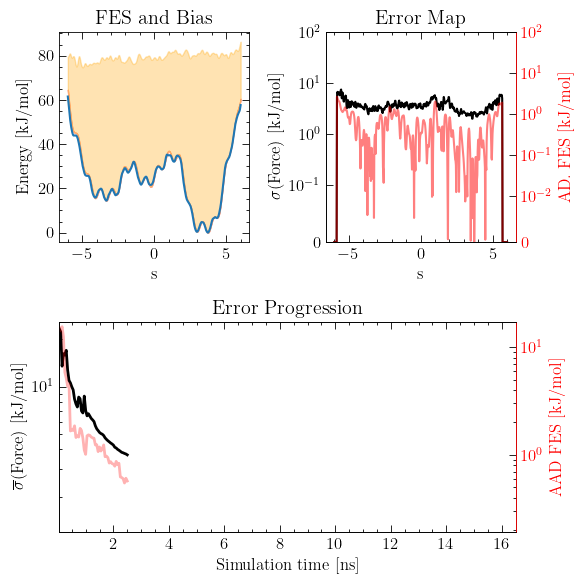

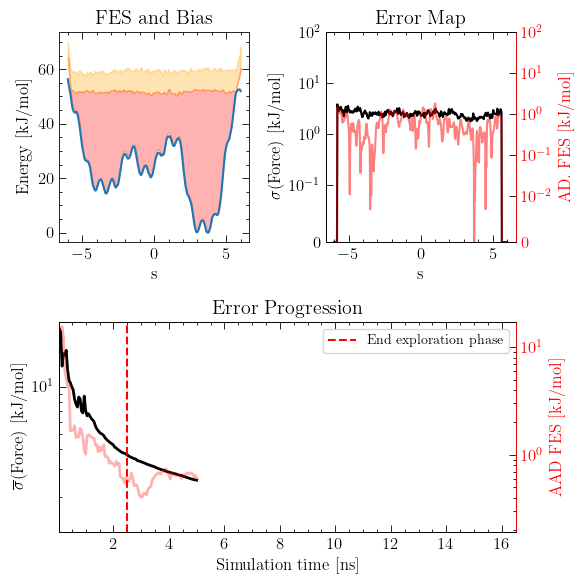

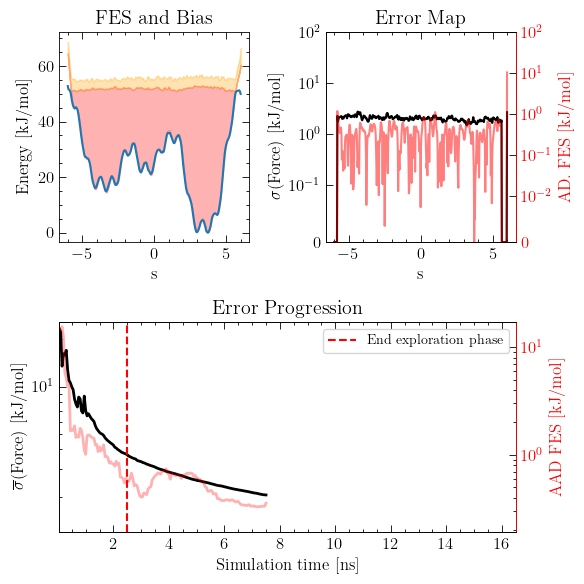

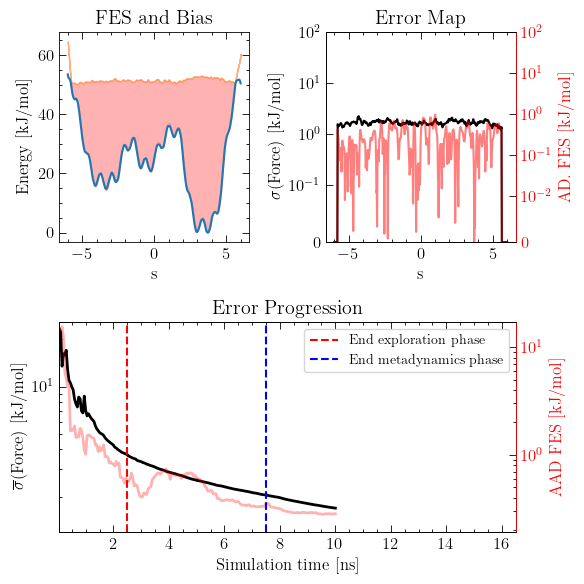

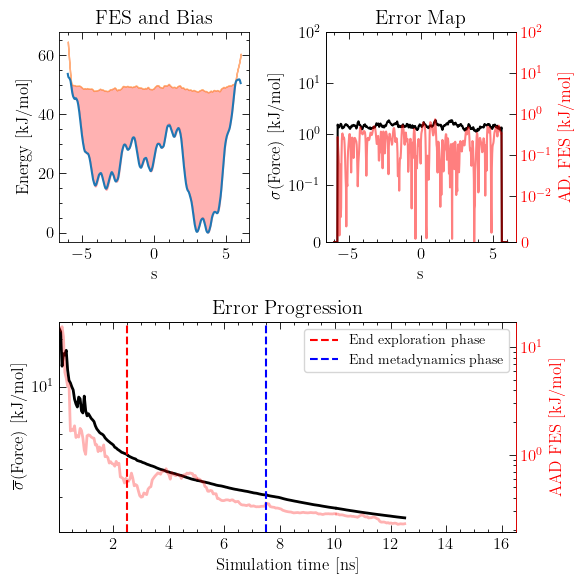

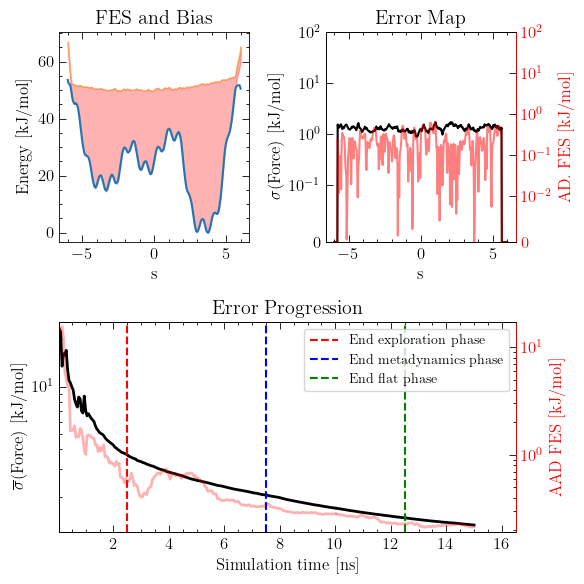

In [17]:
# #### Plot MFI1

# make_nice_figure(t_range=t_range, aofe_range=aofe_range, aad_range=aad_range)

make_nice_figure(MFI, t_range=t_range, aofe_range=aofe_range, aad_range=aad_range)

make_nice_figure(MFI, MFI2, end_exploration=0, t_range=t_range, aofe_range=aofe_range, aad_range=aad_range)

make_nice_figure(MFI, MFI2, MFI3, end_exploration=0, t_range=t_range, aofe_range=aofe_range, aad_range=aad_range)

make_nice_figure(MFI, MFI2, MFI3, MFI4, end_exploration=0, end_metad=2, t_range=t_range, aofe_range=aofe_range, aad_range=aad_range)

make_nice_figure(MFI, MFI2, MFI3, MFI4, MFI5, end_exploration=0, end_metad=2, t_range=t_range, aofe_range=aofe_range, aad_range=aad_range)

make_nice_figure(MFI, MFI2, MFI3, MFI4, MFI5, MFI6, end_exploration=0, end_metad=2, end_flat=4, t_range=t_range, aofe_range=aofe_range, aad_range=aad_range)